# Lared data preparation

This script contains helper methods to deal with the LaRED dataset. 
Some lines of code like paths have to be adjusted for your case. All needed adjustments are marked with "Todo". 
You can find more about the LaRED dataset here: http://mclab.citi.sinica.edu.tw/dataset/lared/lared.html

Before you continue:

1) Download data: http://mclab.citi.sinica.edu.tw/dataset/lared/lared.html#download

2) Uncompress the downloaded files into one folder.

In [1]:
import os
import numpy as np
import cv2
from shutil import copyfile
import csv
import random
import os
import matplotlib.pyplot as plt
from shutil import copyfile
%matplotlib inline

### Set necessary parameters

Look up the gestures here: http://mclab.citi.sinica.edu.tw/dataset/lared/lared.html#abstract

In [2]:
# Todo: select gestures
gestures_dict = {
    'fist':  "/G001/O001/",
    'peace': "/G004/O001/",
    'palm':  "/G008/O001/",
    'five':  "/G014/O001/",
    'crawl': "/G016/O001/",
}

# Todo: change path to uncompressed data folder
DIR_UNCOMPRESSED_IMAGES = "D:/Dimitri/datasets/lared/uncompressed/"

# don't change, mask size is fixed
MASK_WIDTH = 320
MASK_HEIGHT = 240

#### Parameters for detection preprocessing

In [3]:
# Todo: Change image size if necessary. Original image size is 640x480
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
# image width will be cropped to this size
IMAGE_WIDTH_CROPPED = 300

#### Parameters for classification preprocessing

In [4]:
# Todo: Change image size if necessary. Original image size is 640x480
IMAGE_WIDTH_CLASSIFICATION = 64
IMAGE_HEIGHT_CLASSIFICATION = 64

### Helper methods

In [5]:
def write_csv(filename, content):
    """creates an new .csv file and adds the the content provided to the file. 
    Parameters:
        filename (str): eg. filename.csv will create the csv file in the working directory.
        content ([str]): list of strings to be added to csv, eg. [[line1], [line2]]
    """
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(content)
        
def append_csv(filename, content):
    """Ads the the content provided to the file. File has to exist already.
    Parameters:
        filename (str): eg. filename.csv
        content ([str]): list of strings to be added to csv, eg. [[line1], [line2]]
    """

    with open(filename, 'a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(content)
        
def read_csv(filename):
    """ Reads an existing csv file.
    Parameters:
        filename (str): eg. filename.csv
    Returns
        list: all rows in a list
    """
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        return list(reader)

In [6]:
def load_mask(path):
    """ The mask is provided in the following format:  320 by 240 and 8bits-char (row-major binary file)
    This method converts the mask to an image.
    """
    # This method has been created with the help of the following articles:
    # https://stackoverflow.com/questions/17479296/read-in-raw-binary-image-in-python
    # https://stackoverflow.com/questions/31475077/typeerror-data-type-not-understood-in-python-fromfile
    mask = np.fromfile(path, dtype='uint8')
    mask = mask.reshape([MASK_HEIGHT, MASK_WIDTH])
    
    mask = adjust_mask(mask)
    
    return mask


def adjust_mask(mask):
    """ The mask has been created with a different camera thas the actual images. 
    The depth and image camera seemed to be places side by side, wich results in a horizontal shift.
    This method fixes the mask to match the images better.
    """
    
    horizontal_shift = -20
    vertical_shift = 3
    
    # 40, 30 is the difference between depth camera and image camera, 
    # + 12, +9 add a little border around hand, since the mask doesnt match the rgb image exactly
    m_leftright = 40 + 12
    m_topbottom = 30 + 9
    
    x,y,w,h = 0 + m_leftright + horizontal_shift, 0 + m_topbottom + vertical_shift, 320 - m_leftright + horizontal_shift, 240 - m_topbottom + vertical_shift
    mask = mask[y:h, x:w]
    
    # adjust mask to image size
    mask = cv2.resize(mask, (IMAGE_WIDTH,IMAGE_HEIGHT))
    return mask



In [7]:
def collect_images(src_dir, dst_dir, gestures, transform_function):
    """ Iterates over all images from the selected gestures. 
    Applies the provided transform function to all images and 
    Saves the transformed images to the provided dst_dir."""
    
    for gesture_name, gesture_dir in gestures_dict.items():
        if not os.path.exists(dst_dir+"all/"+gesture_name):
            os.makedirs(dst_dir+"all/"+gesture_name)
    
        for dir_person in os.listdir(src_dir):
            full_gesture_dir = src_dir+dir_person+gesture_dir

            for img_name in os.listdir(full_gesture_dir):
                
                if img_name.endswith(".jpg"):
                    img_path = full_gesture_dir+"/"+img_name
                    mask_file_name = img_name[:15] + "mask_" + img_name[-8:-4]
                    mask_path = full_gesture_dir +"depth/"+mask_file_name
                    
                    img = transform_function(img_path, mask_path, dst_dir)
                    
                    cv2.imwrite(dst_dir+"/all/"+gesture_name+"/"+img_name, img)


### Preprocess methods for classification

In [8]:
def crop_image_with_mask(img_path, mask_path, dst_dir):
    """ Loads one image and its mask. Crops the image with the mask.
    The image is cropped in a square form, even if the mask is rectangular. 
    Tho achieve the square form the coordinate if the shorter side are increased to match the longer side.
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
    mask = load_mask(mask_path)
    
    x,y,w,h = cv2.boundingRect(mask)
    
    # crop a square form
    if w > h:
        y = y - int((w-h)/2)
        h = w    
        #make sure y is within picture
        y = max(y,0)
        y = min(y, IMAGE_HEIGHT-h)

    elif h > w:
        x = x - int((h-w)/2)
        w = h
        #make sure x is within picture
        x = max(x,0)
        x = min(x,IMAGE_WIDTH-w)

    img = img[y:y+h, x:x+w]
    img = cv2.resize(img, (IMAGE_WIDTH_CLASSIFICATION,IMAGE_HEIGHT_CLASSIFICATION))
    
    return img

### Preprocess methods for detection

In [9]:
def crop_width_and_create_box_labels(img_path, mask_path, dst_dir):
    """ Crops the image to a rectangular form. Eg. 300x300.
    Creates bounding boxes with the help if the mask and writed the to a csv file.
    """
    
    mask = load_mask(mask_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
    
    x,y,w,h = cv2.boundingRect(mask)
    xmin,xmax,ymin,ymax = x,x+w,y,y+h
    
    mask_height, mask_width = mask.shape
    ratio = IMAGE_WIDTH/mask_width
    xmin,xmax,ymin,ymax = int(xmin*ratio),int(xmax*ratio),int(ymin*ratio),int(ymax*ratio)
    
    
    # if hand has place on cropped image
    if (xmax - xmin) < IMAGE_WIDTH_CROPPED:
        minx_where_to_crop = max(0, xmax - IMAGE_WIDTH_CROPPED)
        maxx_where_to_crop = min(xmin, IMAGE_WIDTH - IMAGE_WIDTH_CROPPED)

        if maxx_where_to_crop == 0:
            x_where_to_crop = 0
        elif minx_where_to_crop == IMAGE_WIDTH - IMAGE_WIDTH_CROPPED:
            x_where_to_crop = IMAGE_WIDTH - IMAGE_WIDTH_CROPPED
        else:
            x_where_to_crop = random.randrange(minx_where_to_crop, maxx_where_to_crop)

        # crop image
        img = img[0:IMAGE_HEIGHT, x_where_to_crop:x_where_to_crop+IMAGE_WIDTH_CROPPED]
        
        xmin, xmax = xmin - x_where_to_crop, xmax - x_where_to_crop
        
        record = [[os.path.basename(img_path), xmin, xmax, ymin, ymax,1]]
        append_csv(dst_dir + csv_file_name, record)

                
    return img

### Split train test set

In [10]:
def split_train_test(dir_all, dir_train, dir_test):
    """ Splits the images into train and test sets."""
    
    for gesture_dir in os.listdir(dir_all):
        all_img_paths = os.listdir(dir_all+gesture_dir)
     
        train_set = []
        test_set = []
        
        test_set.extend(all_img_paths[-300:]) # take the last 300 gestures for testing, its a dedicated person
        del all_img_paths[-300:]
        test_set.extend(all_img_paths[0::10]) # take additional 208 (every 13th) gestures from other persons
        del all_img_paths[0::10]

        
        train_set.extend(all_img_paths)
        del all_img_paths[:]
        
        print("Rest", len(all_img_paths), "Train", len(train_set), "Test", len(test_set), "(", gesture_dir, ")")

        if not os.path.exists(dir_train+gesture_dir):
            os.makedirs(dir_train+gesture_dir)
        for img_path in train_set:
            src = dir_all+gesture_dir+"/"+img_path
            dst = dir_train+gesture_dir+"/"+img_path
            copyfile(src, dst)
            
        if not os.path.exists(dir_test+gesture_dir):
            os.makedirs(dir_test+gesture_dir)
        for img_path in test_set:
            src = dir_all+gesture_dir+"/"+img_path
            dst = dir_test+gesture_dir+"/"+img_path
            copyfile(src, dst)

In [11]:
def split_train_detection(root_dir):
    """ Splits the images into train and test sets. 
    Also writes the labels from the bounding boxes into  a separate csv file.
    """
    
    csv_file_name = 'labels_train_detection.csv'
    csv_header = [['frame','xmin','xmax','ymin','ymax','class_id']]
    write_csv(root_dir + csv_file_name, csv_header)

    dst_dir = root_dir+"train_detection/"
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    
    csv_list = read_csv(root_dir + '/labels_all.csv')[1:] # read labels without header
    
    for gesture_name, _ in gestures_dict.items():
        src_gesture_dir = root_dir+"train/"+gesture_name + "/"

        img_names = os.listdir(src_gesture_dir)[0::5]
        print(len(img_names), gesture_name, "gestures to train_detection added")
        
        for img_name in img_names:
            csv_record = [item for item in csv_list if item[0] == img_name]

            append_csv(root_dir + csv_file_name, csv_record)

            src = src_gesture_dir + img_name
            dst = dst_dir + img_name
            copyfile(src, dst)
            
    print(root_dir + csv_file_name, "file saved")

### Preprocess images for classification

Collect all images for the selected gestures. 

Crop the gestures within the image with the help of the mask.

Resize the images to the defined classification size.

In [12]:
# Todo: define the destination folder for transformed images.
DST_DIR = "C:/datasets/lared/cropped_gesture64x64/"

if not os.path.exists(DST_DIR):
    os.makedirs(DST_DIR)

collect_images(DIR_UNCOMPRESSED_IMAGES, DST_DIR, gestures=gestures_dict, transform_function=crop_image_with_mask)

split_train_test(DST_DIR+"all/", DST_DIR+"train/", DST_DIR+"test/")

Rest 0 Train 2430 Test 570 ( crawl )
Rest 0 Train 2430 Test 570 ( fist )
Rest 0 Train 2430 Test 570 ( five )
Rest 0 Train 2430 Test 570 ( palm )
Rest 0 Train 2430 Test 570 ( peace )


### Preprocess images for detection

Collect all images for the selected gestures.

Crop the image width.

Save bounding boxes to csv file.

In [13]:
# Todo: define the destination folder for transformed images.
DST_DIR = "C:/datasets/lared/300x300/"
if not os.path.exists(DST_DIR):
    os.makedirs(DST_DIR)

csv_file_name = 'labels_all.csv'
csv_header = [['frame','xmin','xmax','ymin','ymax','class_id']]
write_csv(DST_DIR + csv_file_name, csv_header)

collect_images(DIR_UNCOMPRESSED_IMAGES, DST_DIR, gestures=gestures_dict, transform_function=crop_width_and_create_box_labels)

split_train_test(DST_DIR+"all/", DST_DIR+"train/", DST_DIR+"test/")

split_train_detection(DST_DIR)

Rest 0 Train 2430 Test 570 ( crawl )
Rest 0 Train 2430 Test 570 ( fist )
Rest 0 Train 2430 Test 570 ( five )
Rest 0 Train 2430 Test 570 ( palm )
Rest 0 Train 2430 Test 570 ( peace )
486 fist gestures to train_detection added
486 peace gestures to train_detection added
486 palm gestures to train_detection added
486 five gestures to train_detection added
486 crawl gestures to train_detection added
C:/datasets/lared/300x300/labels_train_detection.csv file saved


### Test detection boxes

['F001_G001_O001_0011.jpg', '48', '207', '61', '289', '1']


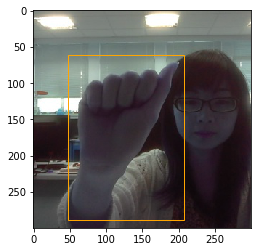

['F001_G004_O001_0011.jpg', '69', '176', '85', '300', '1']


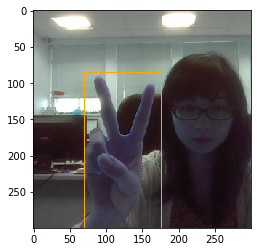

['F001_G008_O001_0011.jpg', '18', '127', '30', '291', '1']


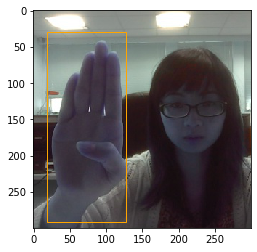

['F001_G014_O001_0011.jpg', '16', '298', '13', '300', '1']


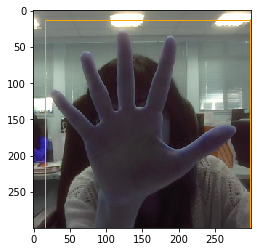

['F001_G016_O001_0011.jpg', '23', '192', '2', '243', '1']


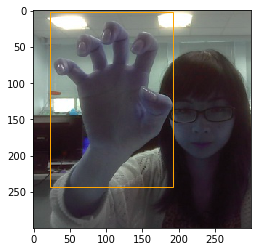

In [15]:
def test_labels_gestures(root_dir, index):
    """ Loops over gesture directories  and displays the image with the bounding box for the specified index."""
    csv_list = read_csv(root_dir + '/labels_all.csv')[1:] # read lebals without header
    
    for gesture_name, _ in gestures_dict.items():
        full_gesture_dir = root_dir+"all/"+gesture_name + "/"       
        img_path = os.listdir(full_gesture_dir)[index]
        csv_record = [item for item in csv_list if item[0] == img_path][0]
        print(csv_record)

        img = cv2.imread(full_gesture_dir + img_path)
        xmin, xmax, ymin, ymax = int(csv_record[1]), int(csv_record[2]), int(csv_record[3]), int(csv_record[4])

        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, facecolor='none', edgecolor="orange")
        plt.gca().add_patch(rectangle)

        plt.imshow(img)
        plt.show()

DST_DIR = "C:/datasets/lared/300x300/"
test_labels_gestures(DST_DIR, index=10)

C:/datasets/lared/300x300/train_detection/M001_G016_O001_0046.jpg


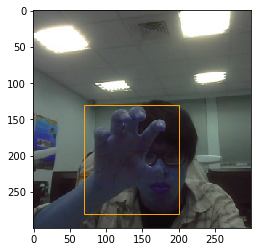

In [29]:
def test_labels_detection(root_dir):
    """ Looks up the train detection folder, where all gestures are in the same folder 
    and shows a random image whith the corresponding bounding box. """
    csv_list = read_csv(root_dir + '/labels_train_detection.csv')[1:] # read lebals without header
    index = random.randint(0, len(csv_list)-1)

    csv_record = csv_list[index]

    img_path = root_dir + "train_detection/"+ csv_record[0]
    print(img_path)
    img = cv2.imread(img_path)

    xmin, xmax, ymin, ymax = int(csv_record[1]), int(csv_record[2]), int(csv_record[3]), int(csv_record[4])

    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, facecolor='none', edgecolor="orange")
    plt.gca().add_patch(rectangle)
    plt.imshow(img)
    
    
DST_DIR = "C:/datasets/lared/300x300/"
test_labels_detection(DST_DIR)